# Data wrangling WeRateDogs

<a id='top'></a>
## Table of Contents
- [Import Packages](#packages)
- [Data Wrangling - Gather](#gather)
- [Data Wrangling - Assess](#assess)
- [Data Wrangling - Clean](#clean)
- [Data visualization and Analysis - Relation between Retweets and Favorites of WeRatesDogs tweets](#interpretation1)
- [Data visualization and Analysis - Rating Numerator evolution over time](#interpretation2)
- [Data visualization and Analysis - Evolution of Retweets and Favorites over time](#interpretation3)
- [Data visualization and Analysis - Top 10 rated dog breeds](#interpretation4)

<a id='packages'></a>
## Import Packages

In [2]:
import pandas as pd
import requests
import numpy as np
import tweepy
import time
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

%matplotlib inline

<a id='gather'></a>
## Data Wrangling - Gather
[Back to top](#top)

### WeRateDogs Twitter archive

In [3]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
twitter_archive.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


###  Tweet images predictions

In [ ]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open('.\Data\image_predictions.tsv', 'wb') as file:
    file.write(response.content)

In [4]:
image_classifier_output = pd.read_csv('image_predictions.tsv', sep='\t')
image_classifier_output.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


### Twitter API call

In [ ]:
consumer_key = 'CONSUMER-KEY'
consumer_secret = 'CONSUMER-SECRET'
access_token = 'ACCESS-TOKEN'
access_secret = 'ACCESS-SECRET'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

In [ ]:
# List of the error tweets
error_list = []
# List of tweets
df_list = []
# Calculate the time of execution
start = time.time()

# For loop which will add each available tweet json to df_list
for tweet_id in twitter_archive['tweet_id']:
    try:
        tweet = api.get_status(tweet_id, tweet_mode='extended')
        favorites = tweet.favorite_count # How many favorites the tweet had
        retweets = tweet.retweet_count # Count of the retweet
        followers_count = tweet.user.followers_count  
        df_list.append({'tweet_id': tweet_id,
                        'favorites': int(favorites),
                        'retweets': int(retweets),
                        'followers_count':int(followers_count)})
    except Exception as e:
        print(str(tweet_id)+ " _ " + str(e))
        error_list.append(tweet_id)
        
# Calculate the time of excution
end = time.time()
print((end - start)/60)

json_tweets = pd.DataFrame(df_list, columns = ['tweet_id', 'favorites', 'retweets','followers_count'])
json_tweets.to_csv('tweet_json.txt', encoding = 'utf-8', index=False)

In [5]:
json_tweets = pd.read_csv('tweet_json.txt')
json_tweets.head(3)

,tweet_id,favorites,retweets,followers_count
0,892420643555336193,38283,8395,7413792
1,892177421306343426,32815,6195,7413792
2,891815181378084864,24707,4100,7413792


<a id='assess'></a>
## Data Wrangling - Assess
[Back to top](#top)

### Assessment steps

In [7]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [8]:
image_classifier_output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [10]:
json_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2342 entries, 0 to 2341
Data columns (total 4 columns):
tweet_id           2342 non-null int64
favorites          2342 non-null int64
retweets           2342 non-null int64
followers_count    2342 non-null int64
dtypes: int64(4)
memory usage: 73.3 KB


In [11]:
twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [12]:
twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [13]:
twitter_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [36]:
twitter_archive.name.value_counts()

None          745
a              55
Charlie        12
Cooper         11
Oliver         11
Lucy           11
Penny          10
Tucker         10
Lola           10
Winston         9
Bo              9
the             8
Sadie           8
Bailey          7
an              7
Buddy           7
Daisy           7
Toby            7
Stanley         6
Scout           6
Milo            6
Oscar           6
Jax             6
Dave            6
Rusty           6
Leo             6
Koda            6
Bella           6
Jack            6
Bentley         5
             ... 
Mutt            1
Kaia            1
Noah            1
Rupert          1
Kellogg         1
Dale            1
Pete            1
Dante           1
Longfellow      1
Jaspers         1
River           1
Ulysses         1
Lillie          1
Tebow           1
Rufio           1
Sweet           1
Josep           1
Ronduh          1
BeBe            1
Butters         1
Kathmandu       1
Peanut          1
Pavlov          1
Grizz           1
Crumpet   

### Assessment summary

#### Quality, *issues with content. Low quality data is also known as dirty data.*
- Drop retweeted rows
- Drop rows without image classifier outputs nor twitter API call outputs
- Fix the dog name extracts
- Clean the rating_numerators and rating_denominators
- Convert the timestamp column to a datetime type
- Convert the tweet_id to string
- Convert the numerator to float to correctly reflect the ratings with decimals
- Convert the value "None" to numpy.nan
- Correct the dog stages with more than one dog stage


#### Tidiness, *issues with structure that prevent easy analysis. Untidy data is also known as messy data.*
- Drop unused columns in twitter_archive and in image_classifier_output
- Merge twitter_archive, image_classifier_output and json_tweets into one dataset
- Unpivot the dog stages into one column

<a id='clean'></a>
## Data Wrangling - Clean
[Back to top](#top)

### Create copies of the dataframes

In [8]:
twitter_archive_work = twitter_archive.copy()
image_classifier_output_work = image_classifier_output.copy()
json_tweets_work = json_tweets.copy()

### Drop unused columns in image_classifier_output
#### Define: 
For our analysis, we will only retain the best result from the image classifier, p1.

#### Code:

In [9]:
image_classifier_output_work.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

In [10]:
image_classifier_output_work.drop(columns=['img_num','p2','p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], inplace=True)

#### Code:

In [11]:
image_classifier_output_work.head(3)

,tweet_id,jpg_url,p1,p1_conf,p1_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,0.465074,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,0.596461,True


### Merge twitter_archive and image_classifier_output in a single file
#### Define:
merge data from the twitter archive and the outpu from the image classifier

#### Code:

In [41]:
master_file = pd.merge(twitter_archive_work, image_classifier_output_work, on=['tweet_id', 'tweet_id'], how='left')

#### Test:

In [42]:
master_file.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,rating_denominator,name,doggo,floofer,pupper,puppo,jpg_url,p1,p1_conf,p1_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,10,Phineas,None,None,None,None,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,orange,0.097049,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,10,Tilly,None,None,None,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,10,Archie,None,None,None,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,True


### Remove rows withouth image classifier details
#### Define:
For our analysis, we are only interested in tweets with image classifier outputs.

#### Code:

In [43]:
master_file = master_file[pd.notna(master_file.p1)]

#### Test:

In [44]:
master_file.p1.value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
malamute                      30
cocker_spaniel                30
French_bulldog                26
miniature_pinscher            23
Chesapeake_Bay_retriever      23
seat_belt                     22
Staffordshire_bullterrier     20
German_shepherd               20
Siberian_husky                20
Cardigan                      19
web_site                      19
teddy                         18
Shetland_sheepdog             18
beagle                        18
Maltese_dog                   18
Eskimo_dog                    18
Lakeland_terrier              17
Rottweiler                    17
Shih-Tzu                      17
Italian_greyhound             16
kuvasz                        16
          

### Remove retweeted entries
#### Define:
For our analysis, we are only interested in original tweets

#### Code:

In [45]:
master_file = master_file[pd.isna(master_file.retweeted_status_id)]

#### Test:

In [46]:
master_file.retweeted_status_id.value_counts()

Series([], Name: retweeted_status_id, dtype: int64)

### Drop unused columns
#### Define:
The columns 'in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp' will not be of any use for our analysis

#### Code:

In [47]:
master_file.drop(columns=['in_reply_to_status_id', 'in_reply_to_user_id','retweeted_status_id', 'retweeted_status_user_id','retweeted_status_timestamp'], inplace=True)

#### Test:

In [48]:
master_file.head(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,jpg_url,p1,p1_conf,p1_dog
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,orange,0.097049,False
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,True
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,True


### Fix dog name extracts
#### Define:
The dog names have been programmatically extracted from the tweet text. It resulted in wrong labelling for dogs when no names were present in the text. The wrong labels are "None" and lowercase values.
Those eroneous entires will be replace by a numpy.nan

#### Code:

In [49]:
replace_list = master_file[master_file['name'].apply(lambda x: x.islower())]['name'].unique().tolist()
replace_list.append('None')
master_file['name'].replace(replace_list, np.nan, inplace=True)

#### Test:

In [50]:
master_file.name.value_counts()

Charlie      11
Oliver       10
Cooper       10
Lucy         10
Penny         9
Tucker        9
Sadie         8
Winston       8
Lola          7
Toby          7
Daisy         7
Jax           6
Koda          6
Bo            6
Stanley       6
Bella         6
Milo          5
Buddy         5
Rusty         5
Dave          5
Chester       5
Bailey        5
Louis         5
Oscar         5
Leo           5
Scout         5
Sophie        4
Gus           4
Bentley       4
Dexter        4
             ..
Skye          1
Brandy        1
Kuyu          1
Clybe         1
Patch         1
Lilly         1
Harnold       1
Brady         1
Kollin        1
Goose         1
Striker       1
Vinscent      1
Hanz          1
Jockson       1
Fillup        1
Andru         1
Billl         1
Chaz          1
Claude        1
Luther        1
Dug           1
Boston        1
Glacier       1
Maxwell       1
Adele         1
Marvin        1
Covach        1
Jareld        1
Autumn        1
Schnitzel     1
Name: name, Length: 913,

### Clean the entries in source
#### Define:
For our analysis, we will clean the source entries for an easier classification

#### Code:

In [51]:
master_file['source'] = master_file['source'].apply(lambda x: re.findall('>(.*)<', x)[0])

#### Test:

In [52]:
master_file.source.value_counts()

Twitter for iPhone    1955
Twitter Web Client      28
TweetDeck               11
Name: source, dtype: int64

### Clean the rating_numerators and rating_denominators
#### Define:
The numerators and denominators have been programmatically extracted from the tweet text. It resulted in wrong labelling in various cases. Those cases will be dealt with in the following section

#### Code:

#### Extract the fraction(s) from the text entries and store it as a list in a new column

In [53]:
pattern = re.compile('(\d{1,2}\S?\d*\/\d{1,3})')
master_file['fractions_extract'] = master_file['text'].apply(lambda x: pattern.findall(x))
master_file.head(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,jpg_url,p1,p1_conf,p1_dog,fractions_extract
0,892420643555336193,2017-08-01 16:23:56 +0000,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,orange,0.097049,False,[13/10]
1,892177421306343426,2017-08-01 00:17:27 +0000,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,True,[13/10]
2,891815181378084864,2017-07-31 00:18:03 +0000,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,True,[12/10]


#### 1st case, the rating_denominator < 10 with 2 fractions_extract

In [54]:
for n in master_file.query('fractions_extract.str.len()==2 & rating_denominator < 10')['tweet_id'].tolist():
    a = master_file[master_file.tweet_id == n]['fractions_extract'].apply(lambda x: x[1].split("/")[0])
    b = master_file[master_file.tweet_id == n]['fractions_extract'].apply(lambda x: x[1].split("/")[1])
    loc_entry = master_file.tweet_id == n
    master_file.loc[loc_entry,'rating_numerator'] = float(a)
    master_file.loc[loc_entry,'rating_denominator'] = float(b)

#### 2nd case, the rating_denominator < 10 with 1 fractions_extract

In [55]:
# The entry will be dropped, no correct rating were present in the tweet text
for n in master_file.query('fractions_extract.str.len()==1 & rating_denominator < 10')['tweet_id'].tolist():
    master_file = master_file[master_file.tweet_id != n]

#### 3rd case, the rating_denominator is 10 and the rating_numerator > 100

In [56]:
# The entry will be dropped, no correct rating were present in the tweet text
for n in master_file.query('rating_numerator > 100 & rating_denominator == 10')['tweet_id'].tolist():
    master_file = master_file[master_file.tweet_id != n]

#### 4th case, the rating_denominator is 10 and the rating_numerator > 20

In [57]:
for n in master_file.query('rating_numerator > 20 & rating_denominator == 10')['tweet_id'].tolist():
    a = master_file[master_file.tweet_id == n]['fractions_extract'].apply(lambda x: x[0].split("/")[0])
    b = master_file[master_file.tweet_id == n]['fractions_extract'].apply(lambda x: x[0].split("/")[1])
    loc_entry = master_file.tweet_id == n
    master_file.loc[loc_entry,'rating_numerator'] = float(a)
    master_file.loc[loc_entry,'rating_denominator'] = float(b)

#### 5th case, the rating_denominator > 10 with 2 fractions_extract

In [58]:
for n in master_file.query('fractions_extract.str.len()==2 & rating_denominator > 10')['tweet_id'].tolist():
    a = master_file[master_file.tweet_id == n]['fractions_extract'].apply(lambda x: x[1].split("/")[0])
    b = master_file[master_file.tweet_id == n]['fractions_extract'].apply(lambda x: x[1].split("/")[1])
    loc_entry = master_file.tweet_id == n
    master_file.loc[loc_entry,'rating_numerator'] = float(a)
    master_file.loc[loc_entry,'rating_denominator'] = float(b)

#### 6th case, the rating_denominator > 10

In [59]:
for n in master_file.query('rating_denominator > 10')['tweet_id'].tolist():
    loc_entry = master_file.tweet_id == n
    a = master_file.loc[loc_entry,'rating_numerator']/(master_file.loc[loc_entry,'rating_denominator']/10)
    b = 10
    master_file.loc[loc_entry,'rating_numerator'] = float(a)
    master_file.loc[loc_entry,'rating_denominator'] = float(b)

#### Test:

In [60]:
master_file.rating_numerator.value_counts()

12.00    454
10.00    421
11.00    403
13.00    262
9.00     152
8.00      95
7.00      51
14.00     36
5.00      33
6.00      32
3.00      19
4.00      15
2.00       9
1.00       4
0.00       2
11.27      1
11.26      1
9.75       1
Name: rating_numerator, dtype: int64

In [61]:
master_file.rating_denominator.value_counts()

10.0    1991
Name: rating_denominator, dtype: int64

#### Drop the fractions_extract column

In [62]:
master_file.drop(columns='fractions_extract', inplace=True)
master_file.head(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,jpg_url,p1,p1_conf,p1_dog
0,892420643555336193,2017-08-01 16:23:56 +0000,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,None,None,None,None,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,orange,0.097049,False
1,892177421306343426,2017-08-01 00:17:27 +0000,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,None,None,None,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,True
2,891815181378084864,2017-07-31 00:18:03 +0000,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,None,None,None,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,True


### Identify the rows with multiple dog stages.
#### Define:
Multiples entries have 2 dog stages. After a quick analysis of the entries, a valid fix is to convert them to 'None' entries

#### Code:

In [63]:
master_file['multiple_dog_stage'] = master_file[['tweet_id','text','doggo', 'floofer','pupper', 'puppo']].isin(['None']).sum(1)
tweet_id_toclean = master_file.query('multiple_dog_stage == 2').tweet_id.tolist()
for n in tweet_id_toclean:
    loc_entry = master_file.tweet_id == n
    master_file.loc[loc_entry, 'doggo'] = 'None'
    master_file.loc[loc_entry, 'floofer'] = 'None'
    master_file.loc[loc_entry, 'pupper'] = 'None'
    master_file.loc[loc_entry, 'puppo'] = 'None'

master_file.drop(columns='multiple_dog_stage', inplace=True)

#### Test:

In [64]:
master_file.head(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,jpg_url,p1,p1_conf,p1_dog
0,892420643555336193,2017-08-01 16:23:56 +0000,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10.0,Phineas,None,None,None,None,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,orange,0.097049,False
1,892177421306343426,2017-08-01 00:17:27 +0000,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,None,None,None,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Chihuahua,0.323581,True
2,891815181378084864,2017-07-31 00:18:03 +0000,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,None,None,None,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Chihuahua,0.716012,True


### Unpivot the dog stages
#### Define:
For our analysis, we will unpivot the dog stages extracted from the tweet text into one column

#### Code:

In [65]:
unpivot_columns = ['doggo', 'floofer', 'pupper', 'puppo']
id_columuns = list(set(master_file.columns.tolist())-set(unpivot_columns))

master_file = pd.melt(master_file, id_vars = id_columuns, value_vars = unpivot_columns, var_name = 'stages', value_name = 'dog_stage')
master_file.drop(columns='stages', inplace=True)

master_file = master_file.sort_values(by=['tweet_id', 'dog_stage'])
master_file.drop_duplicates('tweet_id', keep = 'last', inplace=True)

master_file['dog_stage'].replace('None', np.nan, inplace=True)

#### Test:

In [66]:
master_file.head(3)

,rating_denominator,jpg_url,source,rating_numerator,p1_dog,text,p1_conf,tweet_id,name,expanded_urls,timestamp,p1,dog_stage
7963,10.0,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Twitter for iPhone,8.0,True,Here we have a Japanese Irish Setter. Lost eye...,0.465074,666020888022790149,NaN,https://twitter.com/dog_rates/status/666020888...,2015-11-15 22:32:08 +0000,Welsh_springer_spaniel,NaN
7962,10.0,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,Twitter for iPhone,7.0,True,This is a western brown Mitsubishi terrier. Up...,0.506826,666029285002620928,NaN,https://twitter.com/dog_rates/status/666029285...,2015-11-15 23:05:30 +0000,redbone,NaN
7961,10.0,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,Twitter for iPhone,9.0,True,Here is a very happy pup. Big fan of well-main...,0.596461,666033412701032449,NaN,https://twitter.com/dog_rates/status/666033412...,2015-11-15 23:21:54 +0000,German_shepherd,NaN


In [67]:
master_file.dog_stage.value_counts()

pupper     203
doggo       63
puppo       22
floofer      7
Name: dog_stage, dtype: int64

### Merge with the tweet information obtained from the Twitter API call
#### Define:
Merge the cleaned data with the output from the Twitter API call

#### Code:

In [68]:
master_file = pd.merge(master_file, json_tweets_work, on=['tweet_id', 'tweet_id'], how='left')

#### Test:

In [69]:
master_file.head(3)

,rating_denominator,jpg_url,source,rating_numerator,p1_dog,text,p1_conf,tweet_id,name,expanded_urls,timestamp,p1,dog_stage,favorites,retweets,followers_count
0,10.0,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Twitter for iPhone,8.0,True,Here we have a Japanese Irish Setter. Lost eye...,0.465074,666020888022790149,NaN,https://twitter.com/dog_rates/status/666020888...,2015-11-15 22:32:08 +0000,Welsh_springer_spaniel,NaN,2545.0,508.0,7413842.0
1,10.0,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,Twitter for iPhone,7.0,True,This is a western brown Mitsubishi terrier. Up...,0.506826,666029285002620928,NaN,https://twitter.com/dog_rates/status/666029285...,2015-11-15 23:05:30 +0000,redbone,NaN,129.0,47.0,7413842.0
2,10.0,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,Twitter for iPhone,9.0,True,Here is a very happy pup. Big fan of well-main...,0.596461,666033412701032449,NaN,https://twitter.com/dog_rates/status/666033412...,2015-11-15 23:21:54 +0000,German_shepherd,NaN,125.0,44.0,7413842.0


### Remove row with null values from the Twitter API call
#### Define:
Entries do not have details from the Twitter API call, those entries will be dropped

#### Code:

In [70]:
master_file = master_file[pd.notna(master_file.favorites)]

#### Test:

In [71]:
master_file.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1990 entries, 0 to 1990
Data columns (total 16 columns):
rating_denominator    1990 non-null float64
jpg_url               1990 non-null object
source                1990 non-null object
rating_numerator      1990 non-null float64
p1_dog                1990 non-null object
text                  1990 non-null object
p1_conf               1990 non-null float64
tweet_id              1990 non-null int64
name                  1347 non-null object
expanded_urls         1990 non-null object
timestamp             1990 non-null object
p1                    1990 non-null object
dog_stage             295 non-null object
favorites             1990 non-null float64
retweets              1990 non-null float64
followers_count       1990 non-null float64
dtypes: float64(6), int64(1), object(9)
memory usage: 264.3+ KB


### Clean the datatypes and rename the columns
#### Define:
Convert each columns to their correct data type

#### Code:

In [72]:
# Clean data types
master_file['tweet_id'] = master_file['tweet_id'].astype('str')
master_file['followers_count'] = master_file['followers_count'].astype('int')
master_file['favorites'] = master_file['favorites'].astype('int')
master_file['retweets'] = master_file['retweets'].astype('int')
master_file['rating_denominator'] = master_file['rating_denominator'].astype('int')
master_file['timestamp'] = pd.to_datetime(master_file.timestamp)
master_file['source'] = master_file['source'].astype('category')
master_file['dog_stage'] = master_file['dog_stage'].astype('category')

# Rename columns
master_file.rename(index=str, columns={"p1":"image_classifier_dog_breed", "p1_dog":"dog_breed_test", "text": "tweet_text", "p1_conf":"image_classifier_confidence"}, inplace=True)

#### Test:

In [73]:
master_file.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1990 entries, 0 to 1990
Data columns (total 16 columns):
rating_denominator             1990 non-null int32
jpg_url                        1990 non-null object
source                         1990 non-null category
rating_numerator               1990 non-null float64
dog_breed_test                 1990 non-null object
tweet_text                     1990 non-null object
image_classifier_confidence    1990 non-null float64
tweet_id                       1990 non-null object
name                           1347 non-null object
expanded_urls                  1990 non-null object
timestamp                      1990 non-null datetime64[ns]
image_classifier_dog_breed     1990 non-null object
dog_stage                      295 non-null category
favorites                      1990 non-null int32
retweets                       1990 non-null int32
followers_count                1990 non-null int32
dtypes: category(2), datetime64[ns](1), float64(2), int32

### Store the output

In [74]:
master_file.to_csv('twitter_archive_master.csv', index=False)

<a id='interpretation1'></a>
## Data visualization and Analysis - Relation between Retweets and Favorites of WeRatesDogs tweets
[Back to top](#top)

c:\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


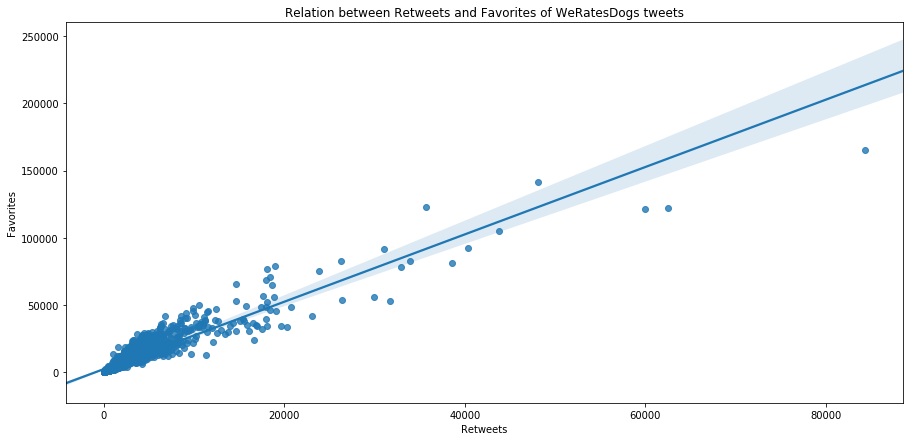

In [75]:
g = sns.regplot(y ='favorites',x='retweets', data=master_file)
g.figure.set_size_inches(15,7)
plt.title('Relation between Retweets and Favorites of WeRatesDogs tweets')
plt.xlabel('Retweets')
plt.ylabel('Favorites');

<a id='interpretation2'></a>
## Data visualization and Analysis - Rating Numerator evolution over Time
[Back to top](#top)

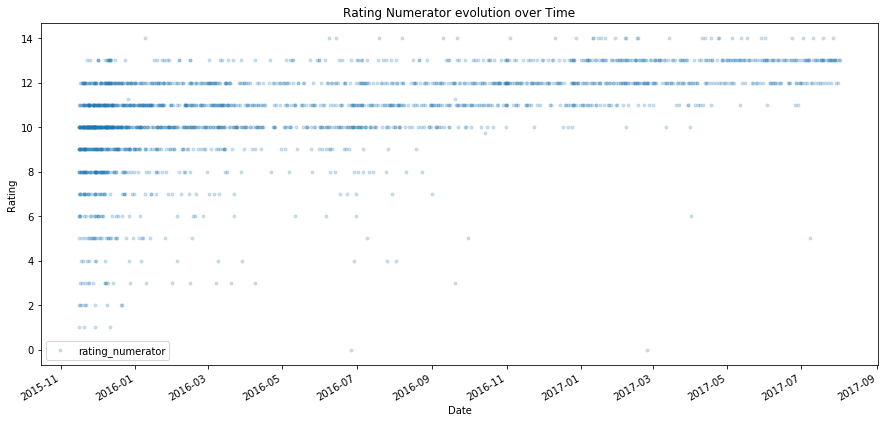

In [76]:
master_file.plot(y ='rating_numerator',x='timestamp', style = '.', alpha = .2, figsize=(15,7))
plt.title('Rating Numerator evolution over Time')
plt.xlabel('Date')
plt.ylabel('Rating');

<a id='interpretation3'></a>
## Data visualization and Analysis - Evolution of Retweets and Favorites over time
[Back to top](#top)

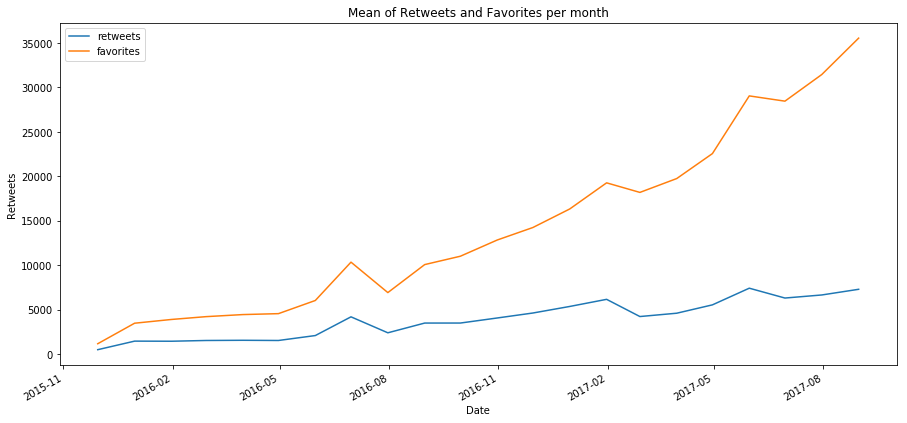

In [77]:
master_file_retweets = master_file[['timestamp','retweets', 'favorites']]
master_file_retweets.index = master_file_retweets['timestamp']

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(master_file_retweets.resample('M').mean().retweets)
ax.plot(master_file_retweets.resample('M').mean().favorites)

fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.legend()
ax.set_title('Mean of Retweets and Favorites per month')
plt.xlabel('Date')
plt.ylabel('Retweets');

<a id='interpretation4'></a>
## Data visualization and Analysis - Top 10 rated dog breeds
[Back to top](#top)

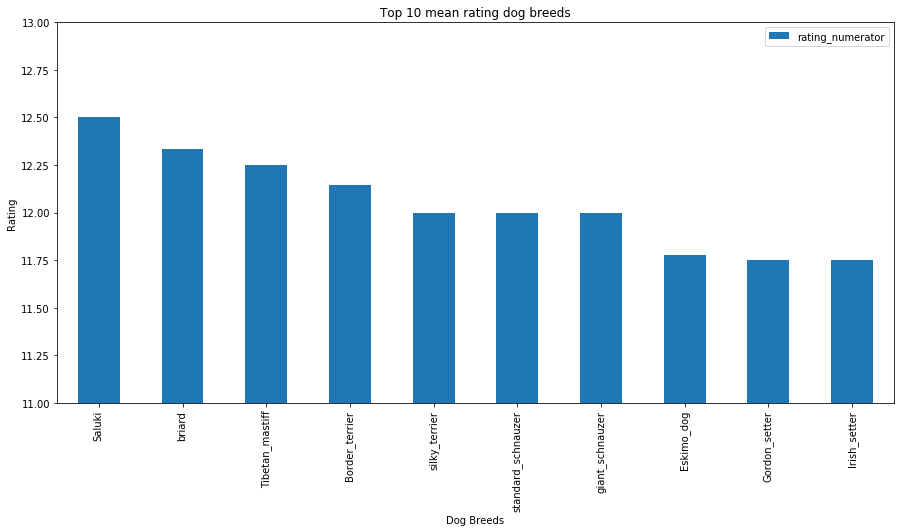

In [78]:
master_file_breed_numerator = master_file.query('dog_breed_test == True')[['rating_numerator','image_classifier_dog_breed']].groupby('image_classifier_dog_breed').mean()
master_file_breed_numerator.sort_values(by='rating_numerator', ascending=False).head(10).plot.bar(figsize=(15,7))
plt.ylim(11,13)
plt.title('Top 10 mean rating dog breeds')
plt.xlabel('Dog Breeds')
plt.ylabel('Rating');